In [169]:
import torch, os
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from train_model import train_model
from test_model import test_model
from inference import get_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pylab import rcParams

rcParams["figure.figsize"] = (20,3)
%matplotlib inline

In [64]:
data_dir = 'tiny-images/'
num_workers = {'train': 4,'val': 0,}
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(20),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    ])
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) 
                  for x in ['train', 'val']}
dataloaders = {x: data.DataLoader(image_datasets[x], batch_size=50, shuffle=False, num_workers=num_workers[x])
                  for x in ['train', 'val',]}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

### Get FineTuned Model for 200 classes

In [76]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# FineTune ResNet18
model = models.resnet18(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(1)
model.fc.out_features = 200

# Get pretrained weights
weights_path = 'models/224/model_10_epoch.pt'
model.load_state_dict(torch.load(weights_path, map_location=device))
model = model.to(device)
model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### See model params. len(params) = 11.689.512

In [176]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [177]:
count_parameters(model)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11689512

### Make prediction for validation test

In [78]:
from collections import Counter
class_mapping = image_datasets['val'].class_to_idx

class_corrects = Counter()

for i, (inputs, labels) in enumerate(dataloaders['val']):
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        outputs = outputs[:, :200]
        _, pred = torch.max(outputs, 1)

    if len(set(labels.tolist())) != 1:
        print('not in one class')
        break
    corrects = torch.sum(labels.data == pred)
    curr_l = labels[0].item()
    class_corrects[curr_l] += corrects

### See the most easy to recognize classes

In [151]:
class_mapping = {v:k for k, v in class_mapping.items()}
class_corrects = dict(sorted(class_corrects.items(), key=lambda x: x[1], reverse=True))
words = pd.read_csv('words.txt', sep='\t', header=None)
words = words.set_index(0).T.to_dict('list')

print('Top 20 easy classes:')
for i, elem in enumerate(list(class_corrects.items())[:20]):
    print('{}. {}[{}] - {}/50 -- ({})'.format(i+1, class_mapping[elem[0]], elem[0], elem[1], 
                                              words[class_mapping[elem[0]]][0].split(', ')[:3]))

Top 20 easy classes:
1. n02917067[81] - 49/50 -- (['bullet train', 'bullet'])
2. n02074367[23] - 47/50 -- (['dugong', 'Dugong dugon'])
3. n01443537[0] - 46/50 -- (['goldfish', 'Carassius auratus'])
4. n02423022[52] - 46/50 -- (['gazelle'])
5. n03544143[109] - 46/50 -- (['hourglass'])
6. n04146614[145] - 46/50 -- (['school bus'])
7. n01768244[6] - 45/50 -- (['trilobite'])
8. n02094433[25] - 45/50 -- (['Yorkshire terrier'])
9. n02279972[44] - 45/50 -- (['monarch', 'monarch butterfly', 'milkweed butterfly'])
10. n02509815[58] - 45/50 -- (['lesser panda', 'red panda', 'panda'])
11. n07920052[193] - 44/50 -- (['espresso'])
12. n02165456[36] - 43/50 -- (['ladybug', 'ladybeetle', 'lady beetle'])
13. n03447447[108] - 43/50 -- (['gondola'])
14. n04118538[143] - 43/50 -- (['rugby ball'])
15. n04487081[166] - 43/50 -- (['trolleybus', 'trolley coach', 'trackless trolley'])
16. n07720875[184] - 43/50 -- (['bell pepper'])
17. n01910747[13] - 42/50 -- (['jellyfish'])
18. n02415577[51] - 42/50 -- (['b

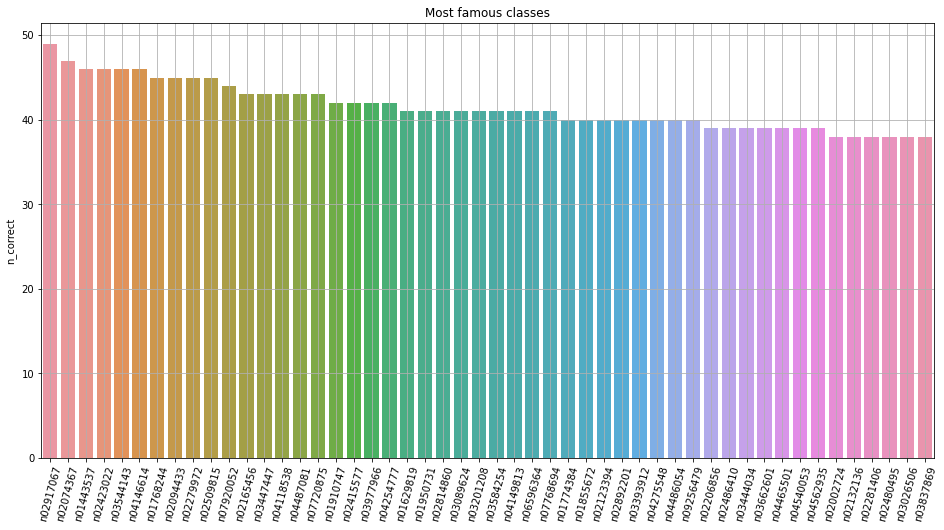

In [171]:
plt.figure(figsize=(16, 8))
top = 50
sns.barplot(x=[class_mapping[i] for i in list(class_corrects.keys())[:top]], y=list(class_corrects.values())[:top]);
plt.xticks(rotation=75);
plt.title('Most famous classes')
plt.ylabel('n_correct')
plt.grid(True)
plt.show()

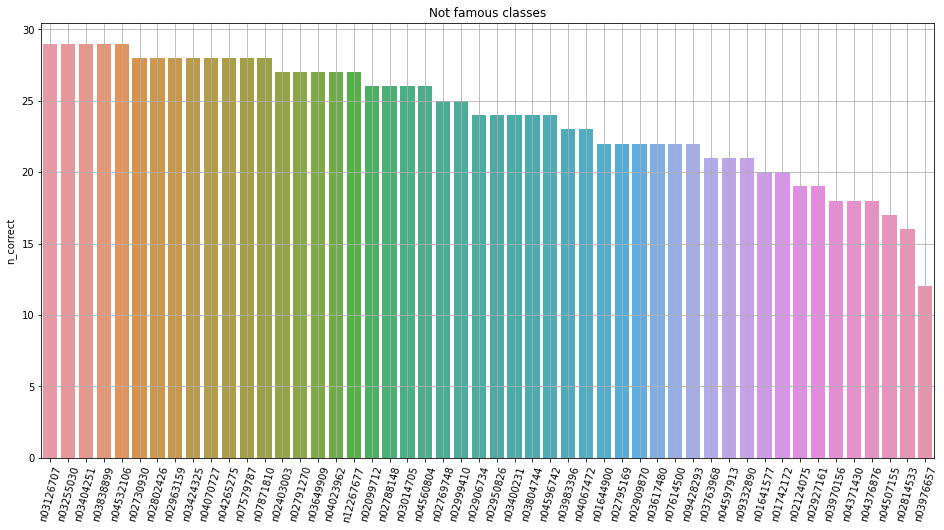

In [172]:
plt.figure(figsize=(16, 8))
top = 50
sns.barplot(x=[class_mapping[i] for i in list(class_corrects.keys())[-top:]], y=list(class_corrects.values())[-top:]);
plt.xticks(rotation=75);
plt.title('Not famous classes')
plt.ylabel('n_correct')
plt.grid(True)
plt.show()

In [173]:
print('Top 20 hard predict classes:')
for i, elem in enumerate(list(class_corrects.items())[-20:]):
    print('{}. {}[{}] - {}/50 -- ({})'.format(i+1, class_mapping[elem[0]], elem[0], elem[1], 
                                              words[class_mapping[elem[0]]][0].split(', ')[:3]))

Top 20 hard predict classes:
1. n04067472[139] - 23/50 -- (['reel'])
2. n01644900[3] - 22/50 -- (['tailed frog', 'bell toad', 'ribbed toad'])
3. n02795169[67] - 22/50 -- (['barrel', 'cask'])
4. n02909870[80] - 22/50 -- (['bucket', 'pail'])
5. n03617480[112] - 22/50 -- (['kimono'])
6. n07614500[179] - 22/50 -- (['ice cream', 'icecream'])
7. n09428293[198] - 22/50 -- (['seashore', 'coast', 'seacoast'])
8. n03763968[119] - 21/50 -- (['military uniform'])
9. n04597913[175] - 21/50 -- (['wooden spoon'])
10. n09332890[197] - 21/50 -- (['lakeside', 'lakeshore'])
11. n01641577[2] - 20/50 -- (['bullfrog', 'Rana catesbeiana'])
12. n01742172[5] - 20/50 -- (['boa constrictor', 'Constrictor constrictor'])
13. n02124075[32] - 19/50 -- (['Egyptian cat'])
14. n02927161[82] - 19/50 -- (['butcher shop', 'meat market'])
15. n03970156[131] - 18/50 -- (['plunger', "plumber's helper"])
16. n04371430[158] - 18/50 -- (['swimming trunks', 'bathing trunks'])
17. n04376876[159] - 18/50 -- (['syringe'])
18. n0450